# TruthGen — Fake News Detection & Correction

**Authors:** Reema Ramachandra Kadechkar, Keerthi Turakapalli, Ashwin Shastry Paturi  
**Course:** DS510_03_IN: Artificial Intelligence for Data Science  
**Date:** 2025-09-03

This notebook consolidates the complete pipeline for **fake news detection** (TF‑IDF + Logistic Regression)
and **correction** (Generative AI via Gemini) into a single, polished deliverable suitable for final submission.

**What you can do here:**
1. Load and combine the `Fake.csv` & `True.csv` datasets
2. Preprocess text (normalize, clean, tokenize, remove stopwords, lemmatize)
3. Convert text → features with TF‑IDF (max_features=5000)
4. Train and evaluate a Logistic Regression baseline (Accuracy, Precision, Recall, F1, Confusion Matrix)
5. (Optional) Run the **Correction** stage to rewrite predicted‑fake articles using **Gemini** (Vertex AI)

> **Tip:** This notebook runs locally, but the **Correction** stage is designed for **Google Colab** + **Vertex AI**.

## 1) Setup & Imports

In [19]:
%pip install -q nltk scikit-learn matplotlib pandas

Note: you may need to restart the kernel to use updated packages.


In [20]:
# If you need to install in a notebook, uncomment the line below.
# %pip install -q nltk scikit-learn matplotlib pandas

import os
import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report,
)

import nltk
from nltk.tokenize import wordpunct_tokenize            # no 'punkt' download needed
from nltk.stem import WordNetLemmatizer, PorterStemmer   # Porter works without corpora

# ---- Reproducibility ----
RANDOM_SEED = int(os.getenv("RANDOM_SEED", "42"))
np.random.seed(RANDOM_SEED)

# ---- Plot defaults (optional, consistent visuals) ----
plt.rcParams["figure.figsize"] = (4, 4)

# Paths in Codespaces
FAKE_DATASET = "/workspaces/DS510-Team-Project/Datasets/Fake.csv"
TRUE_DATASET = "/workspaces/DS510-Team-Project/Datasets/True.csv"

## 2) Load & Combine Dataset

In [21]:
def load_datasets(
    fake_path: str = FAKE_DATASET,
    true_path: str = TRUE_DATASET,
    seed: int = RANDOM_SEED,
) -> pd.DataFrame:
    
    """Load and combine fake and true news datasets."""
    
    if not os.path.exists(fake_path):
        raise FileNotFoundError(f"Fake dataset not found: {fake_path}")
    if not os.path.exists(true_path):
        raise FileNotFoundError(f"True dataset not found: {true_path}")

    fake_df = pd.read_csv(fake_path)
    true_df = pd.read_csv(true_path)

    # Assign labels
    fake_df["label"] = 0  # Fake
    true_df["label"] = 1  # Real

    combined = pd.concat([fake_df, true_df], ignore_index=True)

    # Keep only relevant columns
    keep_cols = [c for c in ["title", "text", "subject", "date", "label"] if c in combined.columns]
    combined = combined[keep_cols]

    # Check for required columns
    required = {"title", "text"}
    missing = required - set(combined.columns)
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    # --- Shuffle and reset index ---
    combined = combined.sample(frac=1.0, random_state=seed).reset_index(drop=True)

    # --- Ensure correct dtypes ---
    combined["label"] = combined["label"].astype(int)

    return combined

# Load and display dataset
df = load_datasets()
print("Combined shape:", df.shape)
display(df.head())

Combined shape: (44898, 5)


,title,text,subject,date,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",0
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",1
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",1
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",0
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",1


## 3) Text Preprocessing

In [22]:
# Stopwords: try NLTK; fallback to a built-in set
try:
    from nltk.corpus import stopwords
    STOPWORDS = set(stopwords.words("english"))
except Exception:
    STOPWORDS = set("""
a about above after again against all am an and any are as at be because been before being below
between both but by could did do does doing down during each few for from further had has have
having he he'd he'll he's her here here's hers herself him himself his how how's i i'd i'll i'm i've
if in into is it it's its itself let's me more most my myself of on once only or other ought our
ours ourselves out over own same she she'd she'll she's should so some such than that that's the
their theirs them themselves then there there's these they they'd they'll they're they've this those
through to too under until up very was we we'd we'll we're we've were what what's when when's where
where's which while who who's whom why why's with would you you'd you'll you're you've your yours yourself yourselves
""".split())

# Keep negations as features
STOPWORDS -= {"no", "not", "nor"}

# Normalizer
try:
    nltk.data.find("corpora/wordnet")
    USE_LEMMA = True
    _lemmatizer = WordNetLemmatizer()
    _stemmer = None
except LookupError:
    USE_LEMMA = False
    _lemmatizer = None
    _stemmer = PorterStemmer()

# Text cleaning regex
KEEP_DIGITS = False
CLEAN_RE = re.compile(r"[^a-zA-Z0-9\s]" if KEEP_DIGITS else r"[^a-zA-Z\s]")

def clean_text(s: str) -> str:
    """Lowercase, strip non-allowed chars, collapse whitespace."""
    if not isinstance(s, str):
        return ""
    s = s.lower()
    s = CLEAN_RE.sub(" ", s)
    return re.sub(r"\s+", " ", s).strip()

def preprocess_text(s: str) -> str:
    """
    Clean → tokenize (wordpunct_tokenize; no 'punkt' needed) → stopword filter →
    lemmatize (if wordnet available) else Porter stem (no corpora).
    """
    s = clean_text(s)
    tokens = wordpunct_tokenize(s)
    # Drop empties/stopwords and 1-char tokens
    tokens = [t for t in tokens if t and t not in STOPWORDS and len(t) > 1]
    if USE_LEMMA:
        tokens = [_lemmatizer.lemmatize(t) for t in tokens]
    else:
        tokens = [_stemmer.stem(t) for t in tokens]
    return " ".join(tokens)

def build_body_column(df: pd.DataFrame) -> pd.DataFrame:
    """Combine title + text into a single 'body' column."""
    out = df.copy()
    title = out.get("title", "").fillna("")
    text  = out.get("text", "").fillna("")
    out["body"] = (title + ". " + text).str.strip()
    return out

# Data preprocessing
df = build_body_column(df)
df["body_clean"] = df["body"].apply(preprocess_text)

print("Cleaned sample:")
display(df[["body", "body_clean"]].head())

Cleaned sample:


,body,body_clean
0,Ben Stein Calls Out 9th Circuit Court: Committ...,ben stein call th circuit court commit coup ta...
1,Trump drops Steve Bannon from National Securit...,trump drop steve bannon nation secur council w...
2,Puerto Rico expects U.S. to lift Jones Act shi...,puerto rico expect lift jone act ship restrict...
3,OOPS: Trump Just Accidentally Confirmed He Lea...,oop trump accident confirm leak isra intellig ...
4,Donald Trump heads for Scotland to reopen a go...,donald trump head scotland reopen golf resort ...


## 4) Train/Test Split, TF‑IDF, and Logistic Regression

Primary (LogReg)
Accuracy : 0.9893
Precision: 0.9843
Recall   : 0.9935
F1-score : 0.9888

Classification Report:

              precision    recall  f1-score   support

           0     0.9940    0.9855    0.9897      4696
           1     0.9843    0.9935    0.9888      4284

    accuracy                         0.9893      8980
   macro avg     0.9891    0.9895    0.9893      8980
weighted avg     0.9894    0.9893    0.9893      8980



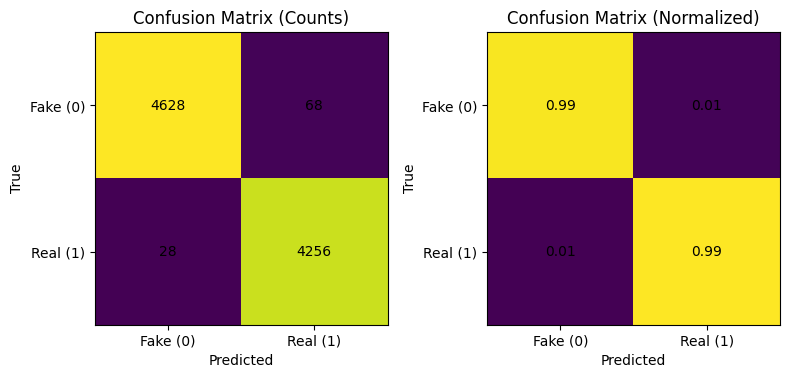

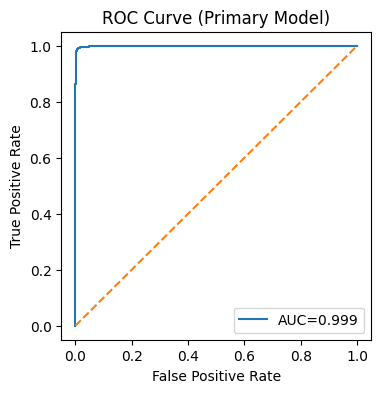

ROC-AUC  : 0.9993

Baseline comparison:


,Model,Acc,Prec,Rec,F1,AUC
1,LinearSVC+Calibrated,0.995434,0.994868,0.995565,0.995216,0.999799
0,LogReg,0.989310,0.984274,0.993464,0.988848,0.999329


Saved model to: /workspaces/DS510-Team-Project/Outputs/tfidf_logreg_pipeline.joblib


In [23]:
# Model training & evaluation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)

# Training data split
X = df["body_clean"].fillna("")
y = df["label"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

# Primary pipeline
model = make_pipeline(
    TfidfVectorizer(max_features=5000, ngram_range=(1, 2)),
    LogisticRegression(
        max_iter=200,
        solver="liblinear",
        class_weight="balanced",
        random_state=RANDOM_SEED,
    ),
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Metrics
def print_metrics(y_true, y_pred, title="Metrics"):
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    print(f"{title}\n"
          f"Accuracy : {acc:.4f}\n"
          f"Precision: {prec:.4f}\n"
          f"Recall   : {rec:.4f}\n"
          f"F1-score : {f1:.4f}\n")
    print("Classification Report:\n")
    print(classification_report(y_true, y_pred, digits=4, zero_division=0))
    return acc, prec, rec, f1

def plot_confusion(y_true, y_pred, labels=("Fake (0)", "Real (1)")):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm / cm.sum(axis=1, keepdims=True)
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(cm)
    ax[0].set_title("Confusion Matrix (Counts)")
    ax[0].set_xticks([0, 1]); ax[0].set_yticks([0, 1])
    ax[0].set_xticklabels(labels); ax[0].set_yticklabels(labels)
    for i in range(2):
        for j in range(2):
            ax[0].text(j, i, cm[i, j], ha="center", va="center")
    ax[0].set_xlabel("Predicted"); ax[0].set_ylabel("True")

    ax[1].imshow(cm_norm)
    ax[1].set_title("Confusion Matrix (Normalized)")
    ax[1].set_xticks([0, 1]); ax[1].set_yticks([0, 1])
    ax[1].set_xticklabels(labels); ax[1].set_yticklabels(labels)
    for i in range(2):
        for j in range(2):
            ax[1].text(j, i, f"{cm_norm[i, j]:.2f}", ha="center", va="center")
    ax[1].set_xlabel("Predicted"); ax[1].set_ylabel("True")
    plt.tight_layout(); plt.show()

def roc_scores(fitted_pipeline, X):
    """Return continuous scores for ROC: prefer predict_proba[:,1], else decision_function, else None."""
    last = fitted_pipeline.steps[-1][1]
    if hasattr(last, "predict_proba"):
        return fitted_pipeline.predict_proba(X)[:, 1]
    if hasattr(last, "decision_function"):
        return fitted_pipeline.decision_function(X)
    return None

# Primary metrics
print_metrics(y_test, y_pred, title="Primary (LogReg)")

plot_confusion(y_test, y_pred)

y_score = roc_scores(model, X_test)
if y_score is not None:
    auc = roc_auc_score(y_test, y_score)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.plot([0, 1], [0, 1], "--")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Primary Model)"); plt.legend(); plt.show()
    print(f"ROC-AUC  : {auc:.4f}")
else:
    print("ROC-AUC: skipped (no continuous scores available).")

# Baselines
baselines = {
    "LogReg": make_pipeline(
        TfidfVectorizer(max_features=5000, ngram_range=(1, 2)),
        LogisticRegression(max_iter=200, solver="liblinear",
                           class_weight="balanced", random_state=RANDOM_SEED),
    ),
    # Calibrate LinearSVC to get probabilities for AUC
    "LinearSVC+Calibrated": make_pipeline(
        TfidfVectorizer(max_features=5000, ngram_range=(1, 2)),
        CalibratedClassifierCV(LinearSVC(), method="sigmoid", cv=3)
    ),
}

rows = []
for name, mdl in baselines.items():
    mdl.fit(X_train, y_train)
    yp = mdl.predict(X_test)
    # Try to compute AUC if possible
    try:
        if hasattr(mdl[-1], "predict_proba"):
            score = mdl.predict_proba(X_test)[:, 1]
        elif hasattr(mdl[-1], "decision_function"):
            score = mdl.decision_function(X_test)
        else:
            score = None
        auc = roc_auc_score(y_test, score) if score is not None else np.nan
    except Exception:
        auc = np.nan

    rows.append((
        name,
        accuracy_score(y_test, yp),
        precision_score(y_test, yp, zero_division=0),
        recall_score(y_test, yp, zero_division=0),
        f1_score(y_test, yp, zero_division=0),
        auc
    ))

baseline_df = pd.DataFrame(rows, columns=["Model", "Acc", "Prec", "Rec", "F1", "AUC"]).sort_values("F1", ascending=False)
print("\nBaseline comparison:")
display(baseline_df)

# Save fitted primary model
from joblib import dump
OUT_DIR = Path("/workspaces/DS510-Team-Project/Outputs")  # adjust if needed
OUT_DIR.mkdir(parents=True, exist_ok=True)
dump(model, OUT_DIR / "tfidf_logreg_pipeline.joblib")
print(f"Saved model to: {OUT_DIR / 'tfidf_logreg_pipeline.joblib'}")

## 5) Keyword Inspection (TF‑IDF)

In [24]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

def _ensure_fitted(step, attr="coef_"):
    if not hasattr(step, attr):
        raise ValueError(
            f"Estimator {type(step).__name__} does not appear fitted "
            f"(missing attribute '{attr}'). Fit your pipeline before calling top-terms."
        )

def _extract_vec_est(pipeline: Pipeline):
    """
    Locate TF-IDF vectorizer and a linear estimator exposing coef_ inside a fitted Pipeline.
    """
    if not isinstance(pipeline, Pipeline):
        raise TypeError("Expected a sklearn Pipeline.")

    vec = None
    est = None

    # Prefer by name
    if hasattr(pipeline, "named_steps"):
        vec = pipeline.named_steps.get("tfidfvectorizer", None)
        est = (pipeline.named_steps.get("logisticregression", None)
               or pipeline.named_steps.get("linearsvc", None)
               or pipeline.named_steps.get("sgdclassifier", None))

    # Fallback by type/attr
    if vec is None or est is None:
        for _, step in getattr(pipeline, "steps", []):
            if vec is None and isinstance(step, TfidfVectorizer):
                vec = step
            if est is None and hasattr(step, "coef_"):
                est = step

    if vec is None:
        raise ValueError("Could not find a TfidfVectorizer in the pipeline.")
    if est is None:
        raise ValueError("Could not find a linear estimator with 'coef_' in the pipeline.")

    _ensure_fitted(est, attr="coef_")
    # Best-effort check that vectorizer was fitted
    if not hasattr(vec, "vocabulary_"):
        raise ValueError("TF-IDF vectorizer does not appear fitted (missing 'vocabulary_').")

    return vec, est

def _weights_for_label(est, class_label):
    """
    Return weights (1D array, shape [n_features]) for requested class label.
    Handles binary LogisticRegression with single-row coef_ by flipping sign
    for the negative class.
    """
    coefs = est.coef_
    classes = np.asarray(getattr(est, "classes_", [0, 1]))

    # Binary logistic regression commonly has shape (1, n_features)
    if coefs.shape[0] == 1 and classes.size >= 2:
        positive_label = classes[1]          # row 0 corresponds to the positive class
        w = coefs[0]
        return w if class_label == positive_label else -w

    # Multiclass (or one-vs-rest with multiple rows)
    if class_label in classes:
        row = int(np.where(classes == class_label)[0][0])
    else:
        # Fall back to first row if label isn't present
        row = 0
    return coefs[row]

def top_terms_pipeline(pipeline: Pipeline, class_label, top_k: int = 20):
    """
    Return list[(term, weight)] of the top +weights for a given class label.
    """
    vec, est = _extract_vec_est(pipeline)
    feature_names = vec.get_feature_names_out()
    w = _weights_for_label(est, class_label)

    if feature_names.shape[0] != w.shape[0]:
        raise ValueError(
            f"Feature dimension mismatch: vectorizer has {feature_names.shape[0]} features, "
            f"but estimator has {w.shape[0]} weights. Ensure you pass the fitted pipeline, "
            "not separately re-fitted components."
        )

    idx = np.argsort(w)[-top_k:][::-1]
    return list(zip(feature_names[idx], w[idx]))

def top_terms_df(pipeline: Pipeline, class_label, top_k: int = 20) -> pd.DataFrame:
    """Return a DataFrame of top terms for convenient display/export."""
    pairs = top_terms_pipeline(pipeline, class_label, top_k=top_k)
    return pd.DataFrame(pairs, columns=["term", "weight"])

def print_top_terms(pipeline: Pipeline, label_real=1, label_fake=0, top_k: int = 20):
    """Pretty-print top terms for the 'real' and 'fake' labels."""
    # Resolve actual labels if the estimator exposes them
    _, est = _extract_vec_est(pipeline)
    if hasattr(est, "classes_"):
        classes = list(est.classes_)
        lbl_real = label_real if label_real in classes else classes[-1]
        lbl_fake = label_fake if label_fake in classes else classes[0]
    else:
        lbl_real, lbl_fake = label_real, label_fake

    print(f"Top terms for class Real ({lbl_real}):")
    for t, w in top_terms_pipeline(pipeline, class_label=lbl_real, top_k=top_k):
        print(f"{t:30s} {w:.4f}")

    print(f"\nTop terms for class Fake ({lbl_fake}):")
    for t, w in top_terms_pipeline(pipeline, class_label=lbl_fake, top_k=top_k):
        print(f"{t:30s} {w:.4f}")

# ---- Usage with your fitted pipeline `model` ----
print_top_terms(model, label_real=1, label_fake=0, top_k=20)

# If you prefer a DataFrame (useful in notebooks/reports):
# top_real_df = top_terms_df(model, class_label=1, top_k=20)
# top_fake_df = top_terms_df(model, class_label=0, top_k=20)
# display(top_real_df); display(top_fake_df)

Top terms for class Real (1):
reuter                         22.3288
said                           14.9143
washington reuter              8.9958
presid donald                  5.0711
wednesday                      4.5406
washington                     4.5318
reuter presid                  4.4051
tuesday                        4.1756
thursday                       3.9191
friday                         3.6433
nov                            3.4581
monday                         3.3079
minist                         3.2462
presidenti                     3.1631
said statement                 3.0216
edt                            2.8966
told report                    2.8488
presid barack                  2.8171
republican                     2.8029
statement                      2.6235

Top terms for class Fake (0):
via                            9.8772
video                          8.6407
us                             6.6859
imag                           5.9664
presid trump             

In [25]:
import nltk

# NLTK: ensure required corpora only if missing
def ensure_nltk():
    needed = [
        ("tokenizers/punkt", "punkt"),
        ("corpora/stopwords", "stopwords"),
        ("corpora/wordnet", "wordnet"),
        ("corpora/omw-1.4", "omw-1.4"),
    ]
    for resource_path, pkg in needed:
        try:
            nltk.data.find(resource_path)
        except LookupError:
            nltk.download(pkg, quiet=True)

ensure_nltk()
print(" NLTK resources ready: punkt, stopwords, wordnet, omw-1.4")

 NLTK resources ready: punkt, stopwords, wordnet, omw-1.4


## 6) Correction Stage: Gemini Rewriting via Vertex AI

> **Note:** This section is intended for **Google Colab** with **Vertex AI** enabled.
It rewrites articles predicted as **fake (label 0)** into factual alternatives using Gemini.

**Steps to enable in Colab:**
1. Runtime → Change runtime type → Python 3, enable GPU (optional)
2. `pip install google-cloud-aiplatform google-generativeai vertexai`
3. Set your **PROJECT_ID** and **LOCATION** (e.g., `us-central1`), ensure you have Vertex AI access
4. Uncomment and run the cells below


In [26]:
# Install Google Cloud + Vertex AI SDKs
%pip install -q --upgrade google-cloud-aiplatform vertexai google-generativeai

Note: you may need to restart the kernel to use updated packages.


In [35]:
# Google Cloud ADC via Service Account JSON (Codespaces-friendly)

import pathlib, json
import os

# Path to your service account JSON key file
DEFAULT_JSON_KEY_PATH = "/workspaces/DS510-Team-Project/GCP_SA_KEY.json"
JSON_KEY_PATH = os.getenv("GOOGLE_APPLICATION_CREDENTIALS", DEFAULT_JSON_KEY_PATH)

key_path = pathlib.Path(JSON_KEY_PATH)

def _validate_sa_json(path: pathlib.Path) -> dict | None:
    if not path.exists():
        return None
    try:
        with path.open("r", encoding="utf-8") as f:
            data = json.load(f)
        # Minimal sanity checks
        if not all(k in data for k in ("type", "project_id", "private_key_id", "client_email")):
            raise ValueError("Missing expected keys in service account JSON.")
        return data
    except Exception as e:
        raise ValueError(f"Invalid service account JSON at {path}: {e}")

sa_info = _validate_sa_json(key_path)

if sa_info:
    # Set ADC env var and confirm
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = str(key_path)
    print(f"✅ Using ADC from JSON file: {key_path}")
    print(f"   project_id: {sa_info.get('project_id')}")
else:
    # No key file found — do not crash. Allow gcloud/Colab auth flows to work.
    # Users can still run: `gcloud auth application-default login` locally,
    # or Colab's `from google.colab import auth; auth.authenticate_user()`
    print("⚠️ Service account key not found. Skipping ADC env setup.")
    print("   Set GOOGLE_APPLICATION_CREDENTIALS to your SA JSON path, or run gcloud ADC login.")

✅ Using ADC from JSON file: /workspaces/DS510-Team-Project/GCP_SA_KEY.json
   project_id: truthgen-ai-news-filter


In [36]:
# Vertex AI init (concise version)
import os
import vertexai
from vertexai.generative_models import GenerativeModel
from google.auth import default as google_auth_default
from google.auth.exceptions import DefaultCredentialsError

try:
    creds, detected_project = google_auth_default()
except DefaultCredentialsError as e:
    raise RuntimeError(
        "No Google credentials. Set GOOGLE_APPLICATION_CREDENTIALS or run: gcloud auth application-default login"
    ) from e

principal = getattr(creds, "service_account_email", None) or getattr(creds, "_service_account_email", None)
if principal:
    print(f"Authenticated principal: {principal}")

PROJECT_ID = os.environ.get("GCP_PROJECT_ID") or detected_project
if not PROJECT_ID:
    raise RuntimeError("PROJECT_ID not resolved. Set GCP_PROJECT_ID or ensure ADC provides a project.")

ALLOWED = {
    "us-central1","us-east1","us-west1","europe-west1","europe-west4",
    "asia-northeast1","asia-east1"
}
LOCATION = os.environ.get("VERTEX_LOCATION", "us-central1")
if LOCATION not in ALLOWED:
    raise ValueError(f"Invalid Vertex AI region '{LOCATION}'. Choose one of: {sorted(ALLOWED)}")

print(f"Project: {PROJECT_ID}")
print(f"Location: {LOCATION}")

vertexai.init(project=PROJECT_ID, location=LOCATION)

# Optional quick check (uncomment to verify access)
# try:
#     GenerativeModel("gemini-1.5-pro").count_tokens("ping")
#     print("Vertex AI generative endpoint reachable.")
# except Exception as e:
#     raise RuntimeError("Vertex AI check failed. Ensure API enabled and IAM permissions set.") from e

Authenticated principal: github-codespaces-access@truthgen-ai-news-filter.iam.gserviceaccount.com
Project: truthgen-ai-news-filter
Location: us-central1


In [37]:
%pip install --upgrade google-cloud-aiplatform vertexai google-generativeai

  Using cached google_cloud_aiplatform-1.111.0-py2.py3-none-any.whl.metadata (38 kB)
  Using cached google_genai-1.33.0-py3-none-any.whl.metadata (43 kB)
  Using cached websockets-15.0.1-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.8 kB)
Note: you may need to restart the kernel to use updated packages.


In [43]:
# --- Dual-path Gemini rewriter: Vertex AI (preferred) -> google-generativeai (fallback) ---
import os, time
import numpy as np
import pandas as pd

# ---------- Config ----------
VERTEX_PROJECT = os.getenv("VERTEX_PROJECT_ID")            # optional; ADC project used if None
VERTEX_REGIONS = [                                         # try these in order
    os.getenv("VERTEX_LOCATION", "us-central1"),
    "us-east1", "europe-west1", "asia-northeast1"
]
VERTEX_MODELS  = [                                         # known-good publisher IDs
    os.getenv("VERTEX_MODEL_NAME") or None,
    "gemini-1.5-pro-002", "gemini-1.5-pro-001",
    "gemini-1.5-flash-002", "gemini-1.5-flash-001",
    "gemini-1.0-pro-001",
]
VERTEX_MODELS  = [m for m in VERTEX_MODELS if m]           # drop Nones
TEMP       = float(os.getenv("VERTEX_TEMPERATURE", "0.2"))
MAX_TOK    = int(os.getenv("VERTEX_MAX_TOKENS", "1024"))
MAX_CHARS  = int(os.getenv("VERTEX_MAX_CHARS", "4000"))

GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")               # set to enable fallback
GEMINI_FALLBACK_MODEL = os.getenv("GEMINI_API_MODEL", "gemini-1.5-pro")

# ---------- Try Vertex AI first ----------
USE_VERTEX = False
vertex_ctx = None
vertex_model = None

def _try_vertex():
    global VERTEX_PROJECT, vertex_ctx, vertex_model
    from google.auth import default as google_auth_default
    from google.auth.exceptions import DefaultCredentialsError
    from google.auth.transport.requests import Request
    import vertexai
    from vertexai.generative_models import GenerativeModel, GenerationConfig

    # ADC + scope
    creds, detected_project = google_auth_default()
    if hasattr(creds, "with_scopes"):
        creds = creds.with_scopes(["https://www.googleapis.com/auth/cloud-platform"])
    creds.refresh(Request())

    project = VERTEX_PROJECT or detected_project
    if not project:
        return False, "No project available from ADC/env."

    # try regions/models
    for region in VERTEX_REGIONS:
        try:
            vertexai.init(project=project, location=region, credentials=creds)
        except Exception as e:
            continue
        for model_name in VERTEX_MODELS:
            try:
                test = GenerativeModel(model_name)
                _ = test.count_tokens("ping")
                cfg = GenerationConfig(temperature=TEMP, max_output_tokens=MAX_TOK)
                return True, dict(project=project, region=region, model=test, gen_cfg=cfg)
            except Exception:
                continue
    return False, "No accessible publisher model across candidate regions/models."

try:
    ok, info = _try_vertex()
    if ok:
        USE_VERTEX = True
        vertex_ctx = info
        print(f"✅ Vertex ready | project={info['project']} region={info['region']} model={type(info['model']).__name__}")
    else:
        print(f"⚠️ Vertex not usable: {info}")
except Exception as e:
    print(f"⚠️ Vertex probe failed: {e}")

# ---------- If Vertex unavailable, try google-generativeai fallback ----------
USE_GAPI = False
gapi_model = None

if not USE_VERTEX and GEMINI_API_KEY:
    try:
        import google.generativeai as genai
        genai.configure(api_key=GEMINI_API_KEY)
        gapi_model = genai.GenerativeModel(GEMINI_FALLBACK_MODEL)
        # light probe
        _ = gapi_model.count_tokens("ping")
        USE_GAPI = True
        print(f"✅ google-generativeai ready | model={GEMINI_FALLBACK_MODEL}")
    except Exception as e:
        print(f"⚠️ google-generativeai probe failed: {e}")

if not USE_VERTEX and not USE_GAPI:
    print("❌ No rewrite backend available. Set GEMINI_API_KEY for fallback or enable Vertex publisher models.")

# ---------- Common utilities ----------
def build_rewrite_prompt(text: str) -> str:
    return (
        "Rewrite the following news article truthfully and concisely, removing any misinformation. "
        "If facts are uncertain, state uncertainty and suggest reliable sources. "
        "Keep a neutral, journalistic tone.\n\nARTICLE:\n" + (text or "")
    )

def _extract_vertex_text(resp):
    try:
        cands = getattr(resp, "candidates", None)
        if cands:
            parts = []
            for c in cands:
                content = getattr(c, "content", None)
                if content and getattr(content, "parts", None):
                    for p in content.parts:
                        t = getattr(p, "text", None)
                        if t: parts.append(t)
            if parts: return "\n".join(parts)
    except Exception:
        pass
    t = getattr(resp, "text", None)
    return t if isinstance(t, str) and t.strip() else None

def rewrite_with_gemini_batch(texts, batch_size: int = 5):
    if not texts: return []
    out = []
    for i in range(0, len(texts), batch_size):
        chunk = texts[i:i+batch_size]
        for t in chunk:
            raw = "" if t is None else str(t)
            raw = raw[:MAX_CHARS]
            prompt = build_rewrite_prompt(raw)
            try:
                if USE_VERTEX:
                    resp = vertex_ctx["model"].generate_content(prompt, generation_config=vertex_ctx["gen_cfg"])
                    txt = _extract_vertex_text(resp) or "[Empty/blocked response]"
                elif USE_GAPI:
                    resp = gapi_model.generate_content(prompt, generation_config={"temperature": TEMP})
                    # google-generativeai has a different shape
                    txt = None
                    try:
                        if resp and resp.candidates:
                            parts = []
                            for c in resp.candidates:
                                if c.content and getattr(c.content, "parts", None):
                                    for p in c.content.parts:
                                        if getattr(p, "text", None): parts.append(p.text)
                            txt = "\n".join(parts) if parts else None
                    except Exception:
                        pass
                    if not txt:
                        # legacy
                        txt = getattr(resp, "text", None) or "[Empty/blocked response]"
                else:
                    head = raw[:280]
                    txt = f"[No rewrite backend configured] {head}{'...' if len(raw)>280 else ''}"
            except Exception as e:
                head = raw[:280]
                txt = f"[Rewrite failed: {e}] {head}{'...' if len(raw)>280 else ''}"
            out.append(txt)
    return out

✅ Vertex ready | project=truthgen-ai-news-filter region=asia-northeast1 model=GenerativeModel


In [ ]:
# --- Dual-path Gemini rewriter + write TOP-50 predicted fakes to corrections.csv ---
import os, time
import numpy as np
import pandas as pd
from pathlib import Path

# ---------- Config ----------
VERTEX_PROJECT = os.getenv("VERTEX_PROJECT_ID")            # optional; ADC project used if None
VERTEX_REGIONS = [
    os.getenv("VERTEX_LOCATION", "us-central1"),
    "us-east1", "europe-west1", "asia-northeast1"
]
VERTEX_MODELS  = [
    os.getenv("VERTEX_MODEL_NAME") or None,
    "gemini-1.5-pro-002", "gemini-1.5-pro-001",
    "gemini-1.5-flash-002", "gemini-1.5-flash-001",
    "gemini-1.0-pro-001",
]
VERTEX_MODELS  = [m for m in VERTEX_MODELS if m]
TEMP       = float(os.getenv("VERTEX_TEMPERATURE", "0.2"))
MAX_TOK    = int(os.getenv("VERTEX_MAX_TOKENS", "1024"))
MAX_CHARS  = int(os.getenv("VERTEX_MAX_CHARS", "2000"))   # trimmed for speed/stability

GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")              # set to enable fallback
GEMINI_FALLBACK_MODEL = os.getenv("GEMINI_API_MODEL", "gemini-1.5-pro")

# ---------- Try Vertex AI first ----------
USE_VERTEX = False
vertex_ctx = None

def _try_vertex():
    from google.auth import default as google_auth_default
    from google.auth.transport.requests import Request
    import vertexai
    from vertexai.generative_models import GenerativeModel, GenerationConfig

    creds, detected_project = google_auth_default()
    if hasattr(creds, "with_scopes"):
        creds = creds.with_scopes(["https://www.googleapis.com/auth/cloud-platform"])
    creds.refresh(Request())

    project = VERTEX_PROJECT or detected_project
    if not project:
        return False, "No project available from ADC/env."

    for region in VERTEX_REGIONS:
        try:
            vertexai.init(project=project, location=region, credentials=creds)
        except Exception:
            continue
        for model_name in VERTEX_MODELS:
            try:
                test = GenerativeModel(model_name)
                _ = test.count_tokens("ping")
                cfg = GenerationConfig(temperature=TEMP, max_output_tokens=MAX_TOK)
                return True, dict(project=project, region=region, model=test, gen_cfg=cfg)
            except Exception:
                continue
    return False, "No accessible publisher model across candidate regions/models."

try:
    ok, info = _try_vertex()
    if ok:
        USE_VERTEX = True
        vertex_ctx = info
        print(f"✅ Vertex ready | project={info['project']} region={info['region']} model={type(info['model']).__name__}")
    else:
        print(f"⚠️ Vertex not usable: {info}")
except Exception as e:
    print(f"⚠️ Vertex probe failed: {e}")

# ---------- If Vertex unavailable, try google-generativeai fallback ----------
USE_GAPI = False
gapi_model = None

if not USE_VERTEX and GEMINI_API_KEY:
    try:
        import google.generativeai as genai
        genai.configure(api_key=GEMINI_API_KEY)
        gapi_model = genai.GenerativeModel(GEMINI_FALLBACK_MODEL)
        _ = gapi_model.count_tokens("ping")
        USE_GAPI = True
        print(f"✅ google-generativeai ready | model={GEMINI_FALLBACK_MODEL}")
    except Exception as e:
        print(f"⚠️ google-generativeai probe failed: {e}")

if not USE_VERTEX and not USE_GAPI:
    print("❌ No rewrite backend available. Set GEMINI_API_KEY for fallback or enable Vertex publisher models.")

# ---------- Common utilities ----------
def build_rewrite_prompt(text: str) -> str:
    return (
        "Rewrite the following news article truthfully and concisely, removing any misinformation. "
        "If facts are uncertain, state uncertainty and suggest reliable sources. "
        "Keep a neutral, journalistic tone.\n\nARTICLE:\n" + (text or "")
    )

def _extract_vertex_text(resp):
    try:
        cands = getattr(resp, "candidates", None)
        if cands:
            parts = []
            for c in cands:
                content = getattr(c, "content", None)
                if content and getattr(content, "parts", None):
                    for p in content.parts:
                        t = getattr(p, "text", None)
                        if t: parts.append(t)
            if parts: return "\n".join(parts)
    except Exception:
        pass
    t = getattr(resp, "text", None)
    return t if isinstance(t, " ".__class__) and t.strip() else None

def rewrite_with_gemini_batch(texts, batch_size: int = 3, per_call_delay: float = 0.25, batch_delay: float = 1.0):
    if not texts: return []
    out = []
    for i in range(0, len(texts), batch_size):
        chunk = texts[i:i+batch_size]
        for t in chunk:
            raw = "" if t is None else str(t)
            raw = raw[:MAX_CHARS]
            prompt = build_rewrite_prompt(raw)
            try:
                if USE_VERTEX:
                    resp = vertex_ctx["model"].generate_content(prompt, generation_config=vertex_ctx["gen_cfg"])
                    txt = _extract_vertex_text(resp) or "[Empty/blocked response]"
                elif USE_GAPI:
                    resp = gapi_model.generate_content(prompt, generation_config={"temperature": TEMP})
                    txt = None
                    try:
                        if resp and resp.candidates:
                            parts = []
                            for c in resp.candidates:
                                if c.content and getattr(c.content, "parts", None):
                                    for p in c.content.parts:
                                        if getattr(p, "text", None): parts.append(p.text)
                            txt = "\n".join(parts) if parts else None
                    except Exception:
                        pass
                    if not txt:
                        txt = getattr(resp, "text", None) or "[Empty/blocked response]"
                else:
                    head = raw[:280]
                    txt = f"[No rewrite backend configured] {head}{'...' if len(raw)>280 else ''}"
            except Exception as e:
                head = raw[:280]
                txt = f"[Rewrite failed: {e}] {head}{'...' if len(raw)>280 else ''}"
            out.append(txt)
            time.sleep(per_call_delay)
        time.sleep(batch_delay)
    return out

# ---------- TOP-50 predicted fakes → write fresh corrections.csv ----------
assert "X_test" in globals() and "y_pred" in globals(), "Need X_test and y_pred from your classifier step."
x_series = X_test.squeeze() if hasattr(X_test, "iloc") else pd.Series(X_test)
y_arr    = np.asarray(y_pred)

fake_idx_all = np.where(y_arr == 0)[0]
top50_idx = fake_idx_all[:50]  # first 50 predicted-as-fake; swap to confidence sort if desired

texts = [str(x_series.iloc[i]) for i in top50_idx]
rewrites = rewrite_with_gemini_batch(texts, batch_size=3, per_call_delay=0.25, batch_delay=1.0)

OUT_DIR = Path("/workspaces/DS510-Team-Project/Outputs"); OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_CSV = OUT_DIR / "corrections.csv"

df_out = pd.DataFrame({
    "index": top50_idx.astype(int),
    "prediction": y_arr[top50_idx].astype(int),
    "original_excerpt": [t[:300] + ("..." if len(t) > 300 else "") for t in texts],
    "rewrite": rewrites,
})

# Overwrite so it contains EXACTLY these 50 rows
df_out.to_csv(OUT_CSV, index=False, encoding="utf-8")
print(f"✅ Wrote exactly {len(df_out)} rewrites to {OUT_CSV}")

try:
    from IPython.display import display
    display(df_out.head(10))
except Exception:
    print(df_out.head(10).to_string(index=False))

✅ Vertex ready | project=truthgen-ai-news-filter region=asia-northeast1 model=GenerativeModel


## 7) Save Artifacts

In [ ]:
import os, time, hashlib
import numpy as np
import pandas as pd
from pathlib import Path
from vertexai.generative_models import GenerativeModel, GenerationConfig

# --- Model Setup ---
assert "vertex_ctx" in globals() and vertex_ctx.get("model"), "Vertex model not initialized"

FAST_MODELS = ["gemini-1.5-flash-002", "gemini-1.5-flash-001"]
model = next((GenerativeModel(name) for name in FAST_MODELS if GenerativeModel(name).count_tokens("ping")), None)

if model:
    print(f"⚡ Using faster model: {getattr(model, 'model_name', getattr(model, 'name', str(model)))}")
else:
    model = vertex_ctx["model"]
    print("ℹ️ Using existing model from vertex_ctx")

GEN_CFG = GenerationConfig(temperature=0.1, max_output_tokens=256)
MAX_CHARS = 1200

# --- Output Setup ---
OUT_DIR = Path("/workspaces/DS510-Team-Project/Outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_CSV = OUT_DIR / "corrections.csv"

# --- Prompt Builder ---
def build_rewrite_prompt(text: str) -> str:
    return (
        "Rewrite the article truthfully and concisely, removing misinformation. "
        "If facts are uncertain, state that and suggest reliable sources. "
        "Neutral, journalistic tone. Keep it under ~6 sentences.\n\nARTICLE:\n" + (text or "")
    )

# --- Text Extraction ---
def extract_text(resp):
    try:
        parts = [
            p.text for c in getattr(resp, "candidates", []) 
            if c.content for p in getattr(c.content, "parts", []) 
            if getattr(p, "text", None)
        ]
        return "\n".join(parts) if parts else None
    except Exception:
        pass
    t = getattr(resp, "text", None)
    return t.strip() if isinstance(t, str) and t.strip() else None

# --- Hashing ---
def hash_text(s: str) -> str:
    return hashlib.sha1(s.encode("utf-8", errors="ignore")).hexdigest()

# --- Resumable State ---
processed_idx, processed_hash = set(), set()
if OUT_CSV.exists():
    try:
        prev = pd.read_csv(OUT_CSV)
        processed_idx = set(prev.get("index", pd.Series()).dropna().astype(int))
        processed_hash = set(prev.get("body_hash", pd.Series()).dropna().astype(str))
    except Exception:
        pass

# --- Data Selection ---
assert "X_test" in globals() and "y_pred" in globals()
x_series = X_test.squeeze() if hasattr(X_test, "iloc") else pd.Series(X_test)
y_pred = np.asarray(y_pred)
fake_idx = [int(i) for i in np.where(y_pred == 0)[0]]

MAX_TO_PROCESS = None
if MAX_TO_PROCESS:
    fake_idx = fake_idx[:MAX_TO_PROCESS]

todo_idx = [i for i in fake_idx if i not in processed_idx]

# --- Adaptive Throttling ---
BATCH_SIZE_INIT = 5
PER_CALL_DELAY, BATCH_DELAY = 0.25, 1.0
RETRIES, BACKOFF = 3, 1.6
ok_streak, err_streak, batch_size = 0, 0, BATCH_SIZE_INIT

def tune_after(success: bool):
    global ok_streak, err_streak, batch_size, PER_CALL_DELAY, BATCH_DELAY
    if success:
        ok_streak += 1
        err_streak = 0
        if ok_streak >= 3:
            batch_size = min(batch_size + 1, 8)
            PER_CALL_DELAY = max(0.15, PER_CALL_DELAY * 0.9)
            BATCH_DELAY = max(0.6, BATCH_DELAY * 0.9)
            ok_streak = 0
    else:
        err_streak += 1
        ok_streak = 0
        batch_size = max(2, batch_size - 1)
        PER_CALL_DELAY = min(0.8, PER_CALL_DELAY * 1.4)
        BATCH_DELAY = min(3.0, BATCH_DELAY * 1.4)

def safe_generate(prompt: str):
    delay = 0.0
    for attempt in range(1, RETRIES + 1):
        if delay: time.sleep(delay)
        try:
            resp = model.generate_content(prompt, generation_config=GEN_CFG)
            txt = extract_text(resp) or "[Empty/blocked response]"
            tune_after(True)
            return txt
        except Exception as e:
            msg = str(e).lower()
            delay = (BACKOFF ** (attempt - 1)) + (0.5 if "429" in msg or "rate" in msg or "quota" in msg else 0)
            if attempt == RETRIES:
                tune_after(False)
                return f"[Rewrite failed after {RETRIES} retries: {e}] {prompt[:220]}{'...' if len(prompt)>220 else ''}"

# --- Rewrite Batch ---
def rewrite_with_gemini_batch(texts):
    out, i = [], 0
    while i < len(texts):
        chunk = texts[i:i+batch_size]
        for t in chunk:
            raw = str(t or "")[:MAX_CHARS]
            prompt = build_rewrite_prompt(raw)
            out.append(safe_generate(prompt))
            time.sleep(PER_CALL_DELAY)
        time.sleep(BATCH_DELAY)
        i += len(chunk)
    return out

# --- Process & Save ---
WINDOW_SIZE = 40
written_total = 0

for start in range(0, len(todo_idx), WINDOW_SIZE):
    window = todo_idx[start:start + WINDOW_SIZE]
    if not window: continue

    texts, hashes, keep_pos = [], [], []
    for i in window:
        raw = str(x_series.iloc[i])
        h = hash_text(raw)
        if h in processed_hash: continue
        texts.append(raw)
        hashes.append(h)
        keep_pos.append(i)

    if not keep_pos: continue

    rewrites = rewrite_with_gemini_batch(texts)

    df_out = pd.DataFrame({
        "index": keep_pos,
        "prediction": y_pred[keep_pos].astype(int),
        "original_excerpt": [t[:300] + ("..." if len(t) > 300 else "") for t in texts],
        "rewrite": rewrites,
        "body_hash": hashes,
    })

    df_out.to_csv(OUT_CSV, mode="a", header=not OUT_CSV.exists(), index=False, encoding="utf-8")
    processed_hash.update(hashes)
    written_total += len(df_out)
    print(f"✅ Wrote {len(df_out)} rows (total this run: {written_total}) → {OUT_CSV}")

# --- Preview ---
try:
    from IPython.display import display
    display(pd.read_csv(OUT_CSV).tail(10))
except Exception:
    print(pd.read_csv(OUT_CSV).tail(10).to_string(index=False))

⚡ Using faster model: <vertexai.generative_models.GenerativeModel object at 0x7db9a057ed20>
✅ Wrote 38 rows (total this run: 38) → /workspaces/DS510-Team-Project/Outputs/corrections.csv
✅ Wrote 39 rows (total this run: 77) → /workspaces/DS510-Team-Project/Outputs/corrections.csv
✅ Wrote 40 rows (total this run: 117) → /workspaces/DS510-Team-Project/Outputs/corrections.csv
✅ Wrote 40 rows (total this run: 157) → /workspaces/DS510-Team-Project/Outputs/corrections.csv
✅ Wrote 40 rows (total this run: 197) → /workspaces/DS510-Team-Project/Outputs/corrections.csv
✅ Wrote 40 rows (total this run: 237) → /workspaces/DS510-Team-Project/Outputs/corrections.csv
✅ Wrote 38 rows (total this run: 275) → /workspaces/DS510-Team-Project/Outputs/corrections.csv
✅ Wrote 39 rows (total this run: 314) → /workspaces/DS510-Team-Project/Outputs/corrections.csv


## 8) Next Steps
- Add alternative baselines (e.g., **LinearSVC**, **RandomForestClassifier**) and compare metrics
- Try transformer embeddings (e.g., **BERT**) for semantic signal
- Introduce **cross-dataset validation** (e.g., LIAR, PolitiFact) to reduce overfitting risk
- Integrate **fact-check APIs** to validate Gemini rewrites
- Add **ethics** & **risk** guardrails (bias, hallucinations, provenance)


## 9) Export Corrections for the Web UI (Streamlit)

This section creates a `corrections.csv` file that the Streamlit UI will read and display
in GitHub Codespaces. It includes article metadata, the model's prediction,
and the corrected text.

In [45]:
from pathlib import Path
import pandas as pd
import numpy as np

OUTPUTS = Path("/workspaces/DS510-Team-Project/Outputs")
OUTPUTS.mkdir(parents=True, exist_ok=True)

# ---- Decide which rows to export ----
# Prefer the test set indices if available; otherwise export from df head.
if 'X_test' in globals() and hasattr(X_test, "index"):
    base_index = X_test.index
else:
    base_index = df.index

# Compute how many rows we can export
max_rows = 200
n_base = len(base_index)
n_pred = len(y_pred) if 'y_pred' in globals() else n_base
export_rows = min(max_rows, n_base, n_pred)

if export_rows == 0:
    raise RuntimeError("Nothing to export: ensure `df` (and optionally `X_test`, `y_pred`) are defined.")

idx_to_use = list(base_index)[:export_rows]

# ---- Choose source text column ----
source_col = "body_clean" if "body_clean" in df.columns else ("body" if "body" in df.columns else "text")
if source_col not in df.columns:
    raise RuntimeError(f"No source text column found. Need one of: body_clean, body, text. Have: {list(df.columns)}")

# ---- Build the UI dataframe safely ----
ui_df = pd.DataFrame({
    "title":   df["title"].reindex(idx_to_use).fillna("").astype(str) if "title"   in df.columns else pd.Series([""]*export_rows, index=idx_to_use),
    "subject": df["subject"].reindex(idx_to_use).fillna("").astype(str) if "subject" in df.columns else pd.Series([""]*export_rows, index=idx_to_use),
    "date":    df["date"].reindex(idx_to_use).fillna("").astype(str) if "date"    in df.columns else pd.Series([""]*export_rows, index=idx_to_use),
    "original_text": df[source_col].reindex(idx_to_use).fillna("").astype(str),
})

# Predictions if available; otherwise fill with -1
if 'y_pred' in globals():
    ui_df["prediction"] = np.asarray(y_pred)[:export_rows].astype(int)
else:
    ui_df["prediction"] = -1

# ---- Generate rewrites using your helper (falls back to identity if not defined) ----
def _rewrite_fallback(texts):
    # Minimal fallback if rewrite_with_gemini_batch is not defined
    return [t for t in texts]

if 'rewrite_with_gemini_batch' in globals():
    rewrites_ui = rewrite_with_gemini_batch(ui_df["original_text"].tolist())
else:
    rewrites_ui = _rewrite_fallback(ui_df["original_text"].tolist())

ui_df["corrected_text"] = rewrites_ui[:export_rows]

# ---- Save for the UI ----
corrections_csv = OUTPUTS / "corrections.csv"
ui_df.to_csv(corrections_csv, index=False)
print("✅ Saved corrections CSV →", corrections_csv)

# Peek
ui_df.head(3)


KeyboardInterrupt: 